# 유용한 특성 선택하기

두 번째 모델의 특성 중요도를 보면 TF-IDF 벡터 특성은 가장 중요한 특성에서 빠져있습니다. 이 특성을 제외하고도 모델의 잘 수행되는지 확인하기 위해 이 특성들을 빼고 세 번째 모델을 훈련해 보겠습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author
)
from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

df = df.loc[df["is_question"]].copy()

2023-06-03 00:12:49.371145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

아래 함수는 특성을 추가합니다. 이 함수에 대한 자세한 내용은 `ml_editor` 소스 코드를 참고하세요.

In [3]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:08<00:00, 924.97it/s] 


In [4]:
feature_arr = ["num_questions",
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# 모델

새로운 특성을 추가했으니 새 모델을 훈련해 보겠습니다. 이전과 동일한 구조를 사용하지만 새로운 특성을 사용합니다. 아래 새로운 특성을 출력해 보겠습니다.

In [5]:
# 추가된 특성이 있으므로 데이터를 다시 분할합니다.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [6]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.0,1022.727273,0.0,2073.863636,35200,...,3.409091,0.000000,1.136364,2.272727,0.000000,1.988636,0.568182,0.000000,3.409091,0.0
2,90.634441,30.211480,60.422961,0.0,60.422961,0.0,1087.613293,0.0,2024.169184,33100,...,4.531722,0.000000,0.000000,1.510574,0.000000,2.416918,0.302115,0.000000,1.208459,0.0
3,175.438596,87.719298,87.719298,0.0,0.000000,0.0,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.877193,6.140351,0.000000,3.508772,1.754386,0.000000,5.263158,0.0
5,70.257611,46.838407,117.096019,0.0,0.000000,0.0,843.091335,0.0,2154.566745,42700,...,3.981265,0.000000,1.170960,0.936768,0.000000,2.810304,0.468384,0.234192,3.044496,0.0
7,135.135135,67.567568,67.567568,0.0,0.000000,0.0,945.945946,0.0,2027.027027,14800,...,2.702703,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.000000,1.351351,0.0


In [7]:
def get_feature_vector_and_label(df, feature_names):
    """
    벡터 특성과 특성 이름으로 입력과 출력 벡터를 생성합니다.
    :param df: 입력 DataFrame
    :param feature_names: (벡터가 아닌) 특성 열의 이름
    :return: 특성 배열과 레이블 배열
    """
    features = df[feature_names].astype(float)
    labels = df["Score"] > df["Score"].median()
    return features, labels

X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [8]:
y_train.value_counts()

Score
False    3483
True     2959
Name: count, dtype: int64

In [9]:
X_test.shape

(1529, 30)

`sklearn`을 사용해 모델을 훈련하고 이전에 설명한 방법으로 성능을 측정합니다.

In [10]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [11]:
def get_metrics(y_test, y_predicted):
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')

    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')

    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참조
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.573, 정밀도 = 0.544, 재현율 = 0.431, f1 = 0.481


In [12]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.595, 정밀도 = 0.609, 재현율 = 0.481, f1 = 0.538


In [13]:
model_path = Path("models/model_3.pkl")
joblib.dump(clf, model_path)

['models/model_3.pkl']

## 특성의 유용성 검증하기

새로운 특성을 모델이 사용하는 확인하기 위해 특성 중요도를 살펴 보겠습니다.

In [14]:
all_feature_names = np.array(feature_arr)

In [15]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_chars: 0.05
num_periods: 0.048
num_questions: 0.048
num_diff_words: 0.047
ADJ: 0.046
ADV: 0.044
AUX: 0.043
DET: 0.043
NOUN: 0.042
ADP: 0.042
PUNCT: 0.041
num_commas: 0.041
PART: 0.041
SCONJ: 0.041
num_stops: 0.04
VERB: 0.04
PRON: 0.04
polarity: 0.039
num_words: 0.038
avg_word_len: 0.037

하위 20개 중요도:

PUNCT: 0.041
num_commas: 0.041
PART: 0.041
SCONJ: 0.041
num_stops: 0.04
VERB: 0.04
PRON: 0.04
polarity: 0.039
num_words: 0.038
avg_word_len: 0.037
PROPN: 0.032
NUM: 0.026
num_colon: 0.022
num_quotes: 0.018
SYM: 0.014
INTJ: 0.012
X: 0.011
num_exclam: 0.007
num_semicolon: 0.007
CONJ: 0


## 예측과 데이터 비교하기

이 섹션은 새로운 모델로 데이터와 예측 비교하기 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/comparing_data_to_predictions.ipynb)에서 설명한 평가 방법을 사용합니다.

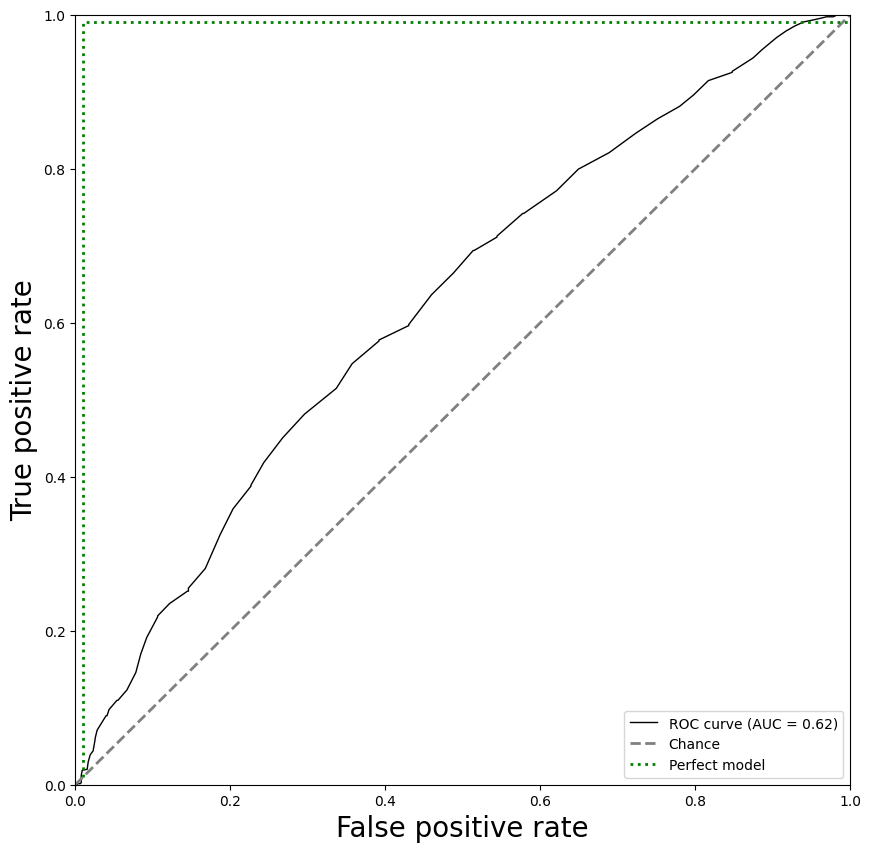

In [16]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

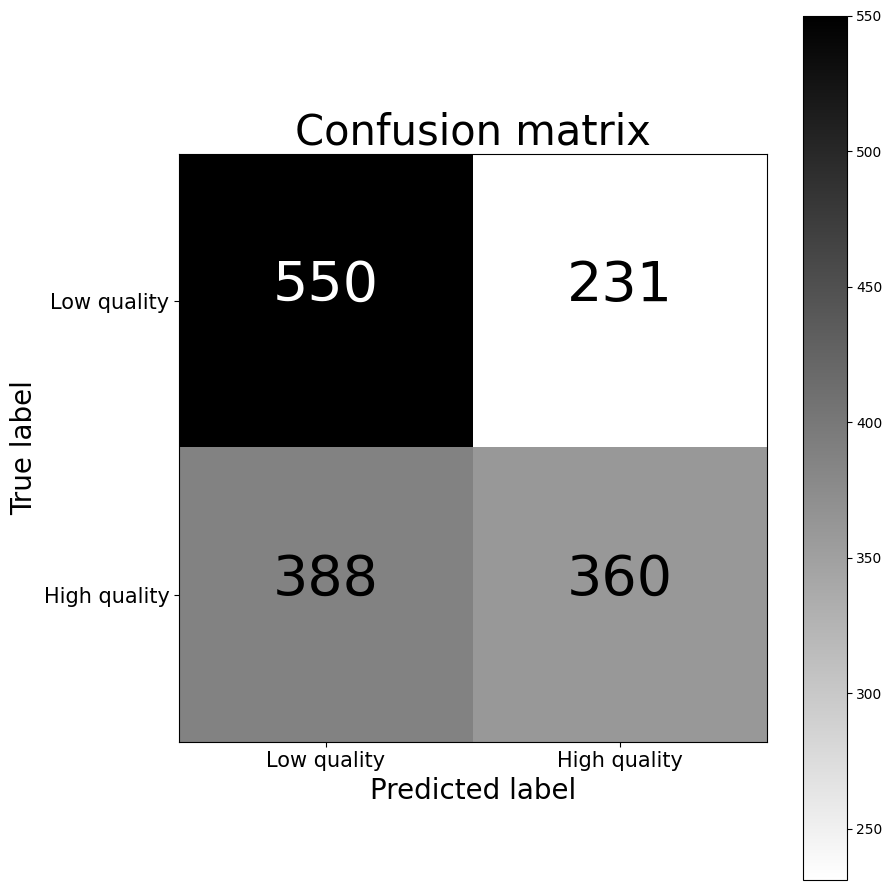

In [17]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.238


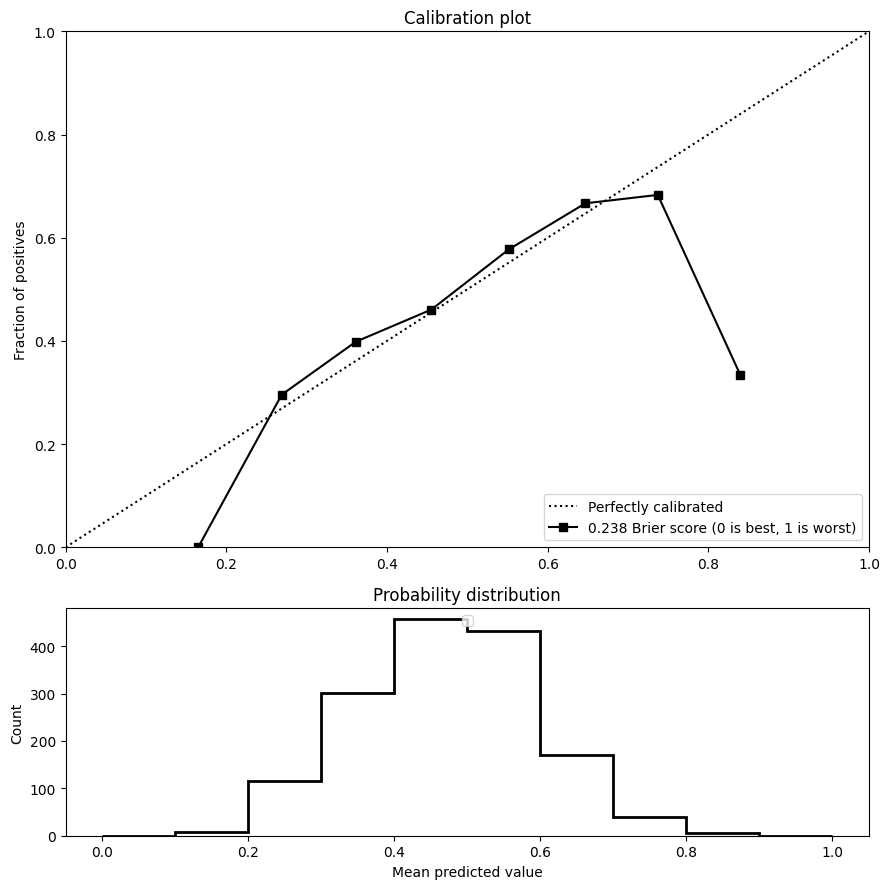

In [18]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

세 번째 모델은 이해하기 쉬운 특성만 사용하고 이전 모델보다 더 보정이 잘 되어 있습니다. 이 애플리케이션에 매우 좋은 후보 모델입니다(자세한 비교 내용은 `Comparing Models`을 참고하세요).

## 추론 함수

이전 두 개의 모델과 마찬가지로 임의의 질문을 받고 높은 점수를 받을 추정 확률을 출력하는 추론 함수를 정의합니다.

In [19]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 1543.16it/s]

0.44 probability of the question receiving a high score according to our model
